# ResNet50 안면 Multi-Label (성별/나이) Classification

In [23]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

### 데이터프레임 로드

* Shuffle된 단일 DataFrame 기준으로 학습
* FamilyData_All(Final)_DF.csv 사용하면 됌

In [24]:
# df=pd.read_csv('data/FamilyData/All(Final)/FamilyData_All(Final)_DF.csv',index_col=0)
df=pd.read_csv('data/FamilyData/All(Final)/FamilyData_All(Final)_DF.csv',index_col=0)
df[:10]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
0,F0085_IND_M_50_45_01.JPG,0,1,0,0,0,0,0,1,0
1,F0877_IND_S2_8_0_02.JPG,1,0,1,0,0,0,0,0,0
2,F0850_IND_D2_9_-45_02.JPG,0,1,1,0,0,0,0,0,0
3,F0448_IND_D_34_45_04.JPG,0,1,0,0,0,1,0,0,0
4,F0179_IND_D_28_90_02.JPG,0,1,0,0,1,0,0,0,0
5,F0369_IND_S_17_0_01.JPG,1,0,0,1,0,0,0,0,0
6,F0419_IND_S_15_45_03.JPG,1,0,0,1,0,0,0,0,0
7,F0712_IND_F_42_90_02.JPG,1,0,0,0,0,0,1,0,0
8,F0857_IND_M_49_45_02.JPG,0,1,0,0,0,0,1,0,0
9,F0086_IND_S_17_-90_01.JPG,1,0,0,1,0,0,0,0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43850 entries, 0 to 43849
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  43850 non-null  object
 1   M         43850 non-null  int64 
 2   F         43850 non-null  int64 
 3   0's       43850 non-null  int64 
 4   10's      43850 non-null  int64 
 5   20's      43850 non-null  int64 
 6   30's      43850 non-null  int64 
 7   40's      43850 non-null  int64 
 8   50's      43850 non-null  int64 
 9   60+       43850 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 3.7+ MB


In [26]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=777, test_size=0.2,shuffle=True)
train_df, val_df = train_test_split(train_df, random_state=777, test_size=0.2,shuffle=True)

len(train_df) , len(val_df), len(test_df)

(28064, 7016, 8770)

In [27]:
train_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
12641,F0172_IND_F_54_-45_02.JPG,1,0,0,0,0,0,0,1,0
31426,F0156_IND_D2_10_0_02.JPG,0,1,0,1,0,0,0,0,0
24020,F0716_IND_M_54_-90_01.JPG,0,1,0,0,0,0,0,1,0
39006,F0433_IND_D_17_0_01.JPG,0,1,0,1,0,0,0,0,0
19718,F0474_IND_M_43_0_05.JPG,0,1,0,0,0,0,1,0,0


In [28]:
val_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
25814,F0295_IND_F_44_90_02.JPG,1,0,0,0,0,0,1,0,0
35670,F0734_IND_D_10_-45_02.JPG,0,1,0,1,0,0,0,0,0
30702,F0492_IND_M_46_90_01.jpg,0,1,0,0,0,0,1,0,0
11591,F0537_IND_D3_17_0_01.jpg,0,1,0,1,0,0,0,0,0
10830,F0273_IND_D_17_0_01.JPG,0,1,0,1,0,0,0,0,0


In [29]:
test_df[:5]

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
19093,F0378_IND_S2_15_0_02.JPG,1,0,0,1,0,0,0,0,0
28729,F0290_IND_D2_14_-90_03.JPG,0,1,0,1,0,0,0,0,0
8603,F0868_IND_D_33_0_01.JPG,0,1,0,0,0,1,0,0,0
10186,F0179_IND_F_54_-45_03.JPG,1,0,0,0,0,0,0,1,0
23428,F0319_IND_S2_30_0_02.JPG,1,0,0,0,0,1,0,0,0


In [30]:
columns= list(df.columns)[1:]
columns

['M', 'F', "0's", "10's", "20's", "30's", "40's", "50's", '60+']

### ImageGenerator 정의

* 엘리베이터 상황 가정, 밝기/확대 다양히
* https://www.datasciencelearner.com/brightness_range-keras-data-augmentation/
* https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

In [31]:
# 밝기 : 0.3~1.0 (0은 검정색)
# zoom : 0.3 => 30퍼센트

datagen=ImageDataGenerator(rescale=1./255.,brightness_range=[0.2,1.0],zoom_range=0.2)
test_datagen=ImageDataGenerator(rescale=1./255.,brightness_range=[0.2,1.0],zoom_range=0.2)

* batch_size=32 시 메모리 오류, 그 이하로 설정

In [32]:
preprocessed_data_path = 'D:/Preprocessed_Datasets(All)/'

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=309,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 28064 validated image filenames.


In [33]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=309,
    shuffle=True,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 7016 validated image filenames.


In [34]:
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=preprocessed_data_path,
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=309,
    shuffle=False,
    color_made='rgb',
    class_mode='other',
    target_size=(224,224))

Found 8770 validated image filenames.


### 모델 정의

* 학습 속도 줄이고 싶을 시 : 일부 전이학습 모델 Layers 삭제

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization

# 레이어 추가 시
# include_top = False 
model_R=ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
output = model_R.output

x= GlobalAveragePooling2D()(output)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)
x= Dense(512,activation='relu')(x) 
x= Dense(256,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.2)(x)

preds=Dense(9,activation='sigmoid')(x) #FC-layer

In [36]:
model=Model(inputs=model_R.input,outputs=preds)
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
          

### GPU 확인

In [37]:
!nvidia-smi

Thu Jul 20 16:39:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   61C    P3    20W /  N/A |   4873MiB /  6144MiB |     43%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        print("gpus available")
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

gpus available
Physical devices cannot be modified after being initialized


### GPU 인식안될 시
### Anaconda Prompt(관리자 권한 실행) - pip uninstall tensorflow - pip install tensorflow==2.10

In [39]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11111519165297427269
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3660578816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12377726198073273886
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [40]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [42]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

### 모델 학습

* 총 epochs =10 으로 설정
* EarlyStopping patience = 2~3 정도
* DenseNet 기준 1 epoch 당 1시간 

In [44]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('models/ResNet50_best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

epochs = 10
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=valid_generator,
                        callbacks=[es, mc])

Epoch 1/10
  2/877 [..............................] - ETA: 18:51 - loss: 0.9207 - acc: 0.1719  

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/conv5_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\user\miniconda3\envs\blue\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\miniconda3\envs\blue\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\miniconda3\envs\blue\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\user\miniconda3\envs\blue\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\user\miniconda3\envs\blue\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_19316\464269382.py", line 9, in <module>
      history = model.fit(train_generator,
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\user\miniconda3\envs\blue\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/conv5_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,7,7,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv5_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_38082]

In [ ]:
pip install matplotlib

     ---------------------------------------- 7.5/7.5 MB 36.9 MB/s eta 0:00:00
     ------------------------------------- 470.4/470.4 kB 28.8 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ---------------------------------------- 1.4/1.4 MB 94.7 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB ? eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
Note: you may need to restart the kernel to use updated packages.


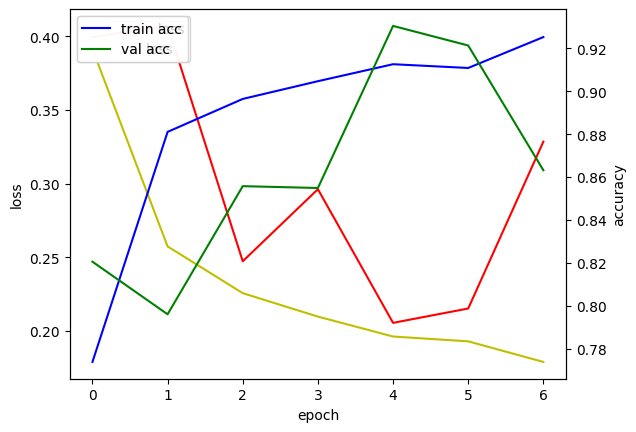

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

### 모델 평가

In [ ]:
model.evaluate(test_generator)

549/549 [==============================] - 1214s 2s/step - loss: 0.3274 - acc: 0.8669


[0.32738909125328064, 0.86693274974823]

In [ ]:
pred=model.predict(test_generator)
pred[0].round(3)

549/549 [==============================] - 1020s 2s/step


array([0.992, 0.008, 0.001, 0.951, 0.059, 0.002, 0.001, 0.   , 0.   ],
      dtype=float32)

In [ ]:
pred[0].argsort()[::-1]

array([0, 3, 4, 1, 5, 2, 6, 7, 8], dtype=int64)

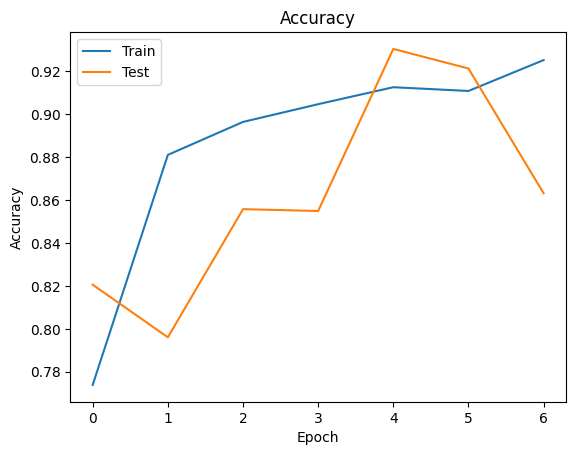

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

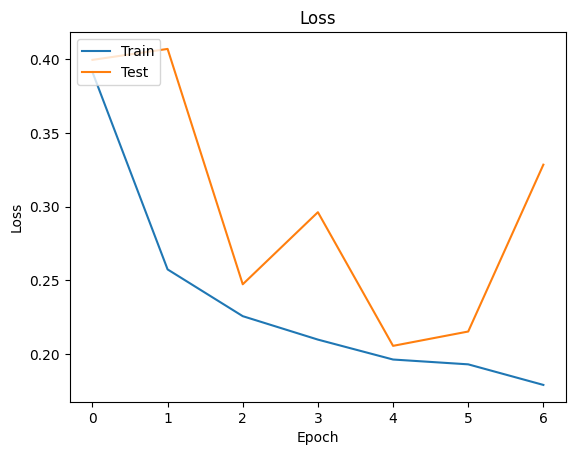

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()